In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu

In [3]:
from keras.layers import Input, LSTM, Embedding, Dense,Flatten
from keras.models import Model
from keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

In [4]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_df=pd.read_csv('/content/drive/MyDrive/ Machine_translation/procedded_data.csv')
train_df.head()

,source,encoder_input,decoder_input,decoder_output
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...
1,ted,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...
3,ted,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...
4,indic2012,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...


In [7]:
def find_length(sentence):
    return len(sentence.split())

In [8]:
train_df['len_encoder_input'] = train_df['encoder_input'].apply(find_length)
train_df['len_decoder_input'] = train_df['decoder_input'].apply(find_length)

In [9]:
train_df.head()

,source,encoder_input,decoder_input,decoder_output,len_encoder_input,len_decoder_input
0,ted,<start> politicians do not have permission to ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...,14,15
1,ted,<start> i would like to tell you about one suc...,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,12,13
2,indic2012,<start> this percentage is even greater than t...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक ह...,12,11
3,ted,<start> what we really mean is that they are b...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते...,15,13
4,indic2012,<start> the ending portion of these vedas is c...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है <en...,11,10


In [10]:
max_len_eng = 16 
max_len_hindi =18 

#select only those rows which have length less than max_length
train_df=train_df[train_df['len_encoder_input']<=max_len_eng] 
train_df=train_df[train_df['len_decoder_input']<=max_len_hindi]
train_df.shape

(73561, 6)

In [11]:
train, cv = train_test_split(train_df, test_size=0.15,random_state=24)
train, test = train_test_split(train, test_size=0.18,random_state=24)
train.shape,cv.shape,test.shape

((51271, 6), (11035, 6), (11255, 6))

In [12]:
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['encoder_input'].values)

vocab_size_eng = len(tknizer_eng.word_index) + 1
vocab_size_eng,max_len_eng

(26221, 16)

In [13]:
tknizer_hindi = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_hindi.fit_on_texts(train['decoder_input'].values)

vocab_size_hindi = len(tknizer_hindi.word_index) + 1
vocab_size_hindi,max_len_hindi

(28768, 18)

In [14]:
#indecies of <start> and <end>
tknizer_eng.word_index['<start>'],tknizer_eng.word_index['<end>']

(1, 2)

In [15]:
tknizer_eng.index_word[1],tknizer_eng.index_word[2]

('<start>', '<end>')

In [16]:
X_train_e=tknizer_eng.texts_to_sequences(train['encoder_input'])
X_train_h=tknizer_hindi.texts_to_sequences(train['decoder_input'])
y_train_h=tknizer_hindi.texts_to_sequences(train['decoder_output'])

X_cv_e=tknizer_eng.texts_to_sequences(cv['encoder_input'])
X_cv_h=tknizer_hindi.texts_to_sequences(cv['decoder_input'])
y_cv_h=tknizer_hindi.texts_to_sequences(cv['decoder_output']) 

X_test_e=tknizer_eng.texts_to_sequences(test['encoder_input'])
X_test_h=tknizer_hindi.texts_to_sequences(test['decoder_input'])
y_test_h=tknizer_hindi.texts_to_sequences(test['decoder_output']) 

In [17]:
X_train_e=pad_sequences(X_train_e,maxlen=max_len_eng,padding='post')
X_train_h=pad_sequences(X_train_h,maxlen=max_len_hindi,padding='post')
y_train_h=pad_sequences(y_train_h,maxlen=max_len_hindi,padding='post')

X_cv_e=pad_sequences(X_cv_e,maxlen=max_len_eng,padding='post')
X_cv_h=pad_sequences(X_cv_h,maxlen=max_len_hindi,padding='post')
y_cv_h=pad_sequences(y_cv_h,maxlen=max_len_hindi,padding='post') 

X_test_e=pad_sequences(X_test_e,maxlen=max_len_eng,padding='post')
X_test_h=pad_sequences(X_test_h,maxlen=max_len_hindi,padding='post')
y_test_h=pad_sequences(y_test_h,maxlen=max_len_hindi,padding='post') 

In [18]:
print(X_train_e.shape,X_train_h.shape,y_train_h.shape)
print(X_cv_e.shape,X_cv_h.shape,y_cv_h.shape)
print(X_test_e.shape,X_test_h.shape,y_test_h.shape)

(51271, 16) (51271, 18) (51271, 18)
(11035, 16) (11035, 18) (11035, 18)
(11255, 16) (11255, 18) (11255, 18)


In [19]:
print(X_train_e.shape)
X_train_e

(51271, 16)


array([[   1,    3,  151, ...,    0,    0,    0],
       [   1,  217,   12, ..., 2044,   47,    2],
       [   1,  792,   15, ...,    0,    0,    0],
       ...,
       [   1, 5326,    2, ...,    0,    0,    0],
       [   1,    6,   76, ...,    0,    0,    0],
       [   1,  180, 1141, ..., 3108,    2,    0]], dtype=int32)

In [20]:
print(X_train_h.shape)
X_train_h

(51271, 18)


array([[    1,   665,   468, ...,     0,     0,     0],
       [    1,    19,  2529, ...,     0,     0,     0],
       [    1,  5498, 15884, ...,     0,     0,     0],
       ...,
       [    1, 11634,     2, ...,     0,     0,     0],
       [    1,     6,   274, ...,     0,     0,     0],
       [    1,   342,   634, ...,     2,     0,     0]], dtype=int32)

In [21]:
print(y_train_h.shape)
y_train_h

(51271, 18)


array([[  665,   468,  1439, ...,     0,     0,     0],
       [   19,  2529,     4, ...,     0,     0,     0],
       [ 5498, 15884,    42, ...,     0,     0,     0],
       ...,
       [11634,     2,     2, ...,     0,     0,     0],
       [    6,   274,    13, ...,     0,     0,     0],
       [  342,   634,     7, ...,     2,     0,     0]], dtype=int32)

In [22]:
def generate_batch(X_e,X_h,y_h,batch_size):
    while True:
        for i in range(0,X_e.shape[0]//batch_size):
            encoder_input = X_e[i*batch_size:(i+1)*batch_size]
            decoder_input = X_h[i*batch_size:(i+1)*batch_size]
            decoder_output_= y_h[i*batch_size:(i+1)*batch_size]
            decoder_output=np.zeros((batch_size,max_len_hindi,vocab_size_hindi))
            for i in range(batch_size):
                for j in range(max_len_hindi):
                    k=decoder_output_[i][j]
                    if k!=0:
                        decoder_output[i][j][k]=1
                    else:
                        continue
            yield([encoder_input, decoder_input], decoder_output)    

In [23]:
#early stopping
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1,mode='min')

In [24]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=4,restore_best_weights=True,mode='min')
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ Machine_translation/best_model.h5',mode='min',save_best_only=True)
cb=[early_stopping,model_checkpoint]

In [25]:
embedding_dim=150
lstm_units=125
batch_size=128

In [26]:
# Encoder
# encoder_inputs = Input(batch_shape=(batch_size,max_len_eng))
encoder_inputs = Input(shape=(None,),name='Encoder_input')
print('Encoder input : ',encoder_inputs.shape)
enc_emb =  Embedding(vocab_size_eng,embedding_dim,name='Encoder_embedding_layer')(encoder_inputs)
print('Encoder after embedding layer : ',enc_emb.shape)
encoder_lstm = LSTM(lstm_units, return_state=True,name='Encoder_lstm_layer')
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
print('Encoder output after lstm : ',encoder_outputs.shape)
print('Encoder state_h after lstm : ',state_h.shape)
print('Encoder state_c after lstm : ',state_c.shape)
print('-'*40)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Encoder input :  (None, None)
Encoder after embedding layer :  (None, None, 150)
Encoder output after lstm :  (None, 125)
Encoder state_h after lstm :  (None, 125)
Encoder state_c after lstm :  (None, 125)
----------------------------------------


In [27]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name='Decoder_input')
print('Decoder inputs : ',decoder_inputs.shape)
dec_emb_layer = Embedding(vocab_size_hindi,embedding_dim,name='Decoder_embedding_layer')
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoder after embedding layer : ',dec_emb.shape)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,name='Decoder_lstm_layer')
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
print('Decoder outputs after lstm : ',decoder_outputs.shape)
decoder_dense = Dense(vocab_size_hindi, activation='softmax',name='Decoder_dense_layer')
decoder_outputs = decoder_dense(decoder_outputs)
print('Decoder outputs after dense layer : ',decoder_outputs.shape)
print('-'*40)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Decoder inputs :  (None, None)
Decoder after embedding layer :  (None, None, 150)
Decoder outputs after lstm :  (None, None, 125)
Decoder outputs after dense layer :  (None, None, 28768)
----------------------------------------


In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_embedding_layer (Embedd (None, None, 150)    3933150     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    4315200     Decoder_input[0][0]              
______________________________________________________________________________________________

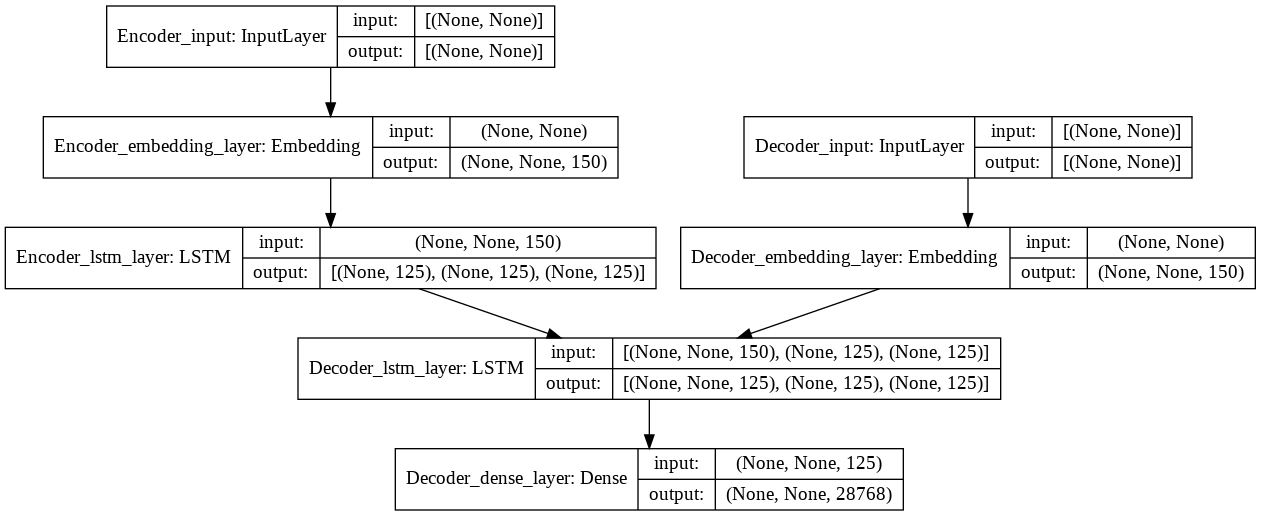

In [30]:
plot_model(model,'model_encoder_decoder.png',show_shapes=True)

In [31]:
train_samples = len(X_train_e)
val_samples = len(X_cv_e)
epochs = 100

In [32]:
hs=model.fit_generator(generator = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_cv_e,X_cv_h,y_cv_h, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,callbacks=cb)

Epoch 1/100
400/400 [==============================] - 147s 317ms/step - loss: 3.9287 - val_loss: 3.3951
Epoch 2/100
400/400 [==============================] - 131s 327ms/step - loss: 3.5641 - val_loss: 3.2120
Epoch 3/100
400/400 [==============================] - 132s 330ms/step - loss: 3.3221 - val_loss: 3.0004
Epoch 4/100
400/400 [==============================] - 129s 322ms/step - loss: 3.1015 - val_loss: 2.8979
Epoch 5/100
400/400 [==============================] - 128s 320ms/step - loss: 2.9580 - val_loss: 2.8069
Epoch 6/100
400/400 [==============================] - 126s 316ms/step - loss: 2.8505 - val_loss: 2.7466
Epoch 7/100
400/400 [==============================] - 125s 314ms/step - loss: 2.7571 - val_loss: 2.6886
Epoch 8/100
400/400 [==============================] - 126s 314ms/step - loss: 2.6666 - val_loss: 2.6515
Epoch 9/100
400/400 [==============================] - 125s 313ms/step - loss: 2.5903 - val_loss: 2.6219
Epoch 10/100
400/400 [==============================] -

In [33]:
model.save_weights('/content/drive/MyDrive/ Machine_translation/encoder_decoder_weights_100-e.h5')

In [34]:
model.load_weights('/content/drive/MyDrive/ Machine_translation/encoder_decoder_weights_100-e.h5')

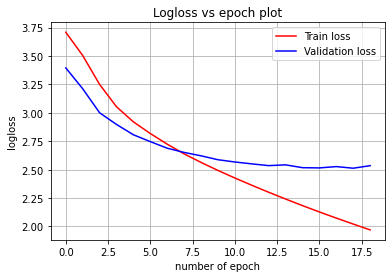

In [35]:
h=hs.history

plt.plot(h['loss'], 'r')
plt.plot(h['val_loss'], 'b')
plt.legend({'Train loss': 'r', 'Validation loss':'b'})
plt.ylabel('logloss')
plt.xlabel('number of epoch')
plt.title('Logloss vs epoch plot')
plt.grid()
plt.show()

In [36]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
 
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(lstm_units,),name='Decoder_state_h')
decoder_state_input_c = Input(shape=(lstm_units,),name='Decoder_state_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [37]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
Encoder_embedding_layer (Emb (None, None, 150)         3933150   
_________________________________________________________________
Encoder_lstm_layer (LSTM)    [(None, 125), (None, 125) 138000    
Total params: 4,071,150
Trainable params: 4,071,150
Non-trainable params: 0
_________________________________________________________________


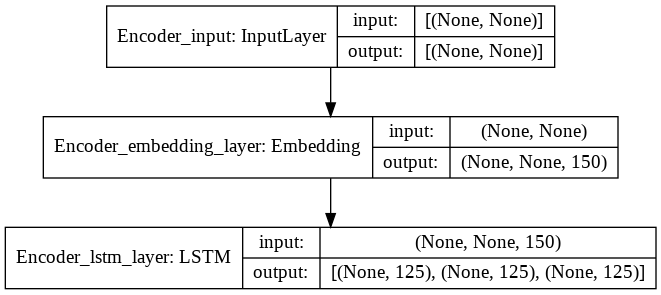

In [38]:
plot_model(encoder_model,'model_encoder_decoder.png',show_shapes=True)

In [39]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_embedding_layer (Embedd (None, None, 150)    4315200     Decoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_state_h (InputLayer)    [(None, 125)]        0                                            
__________________________________________________________________________________________________
Decoder_state_c (InputLayer)    [(None, 125)]        0                                            
____________________________________________________________________________________________

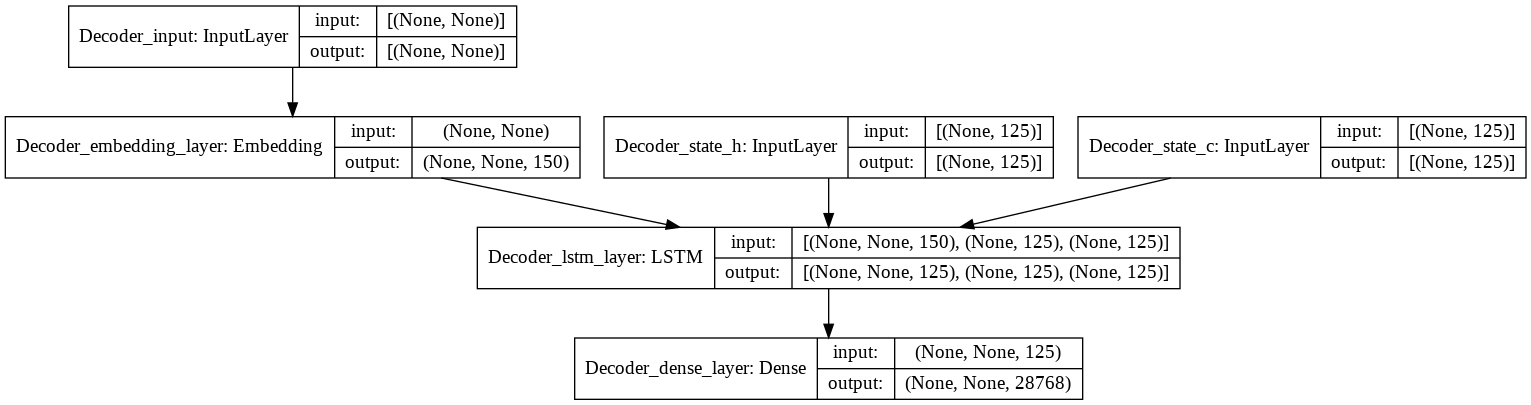

In [40]:
plot_model(decoder_model,'model_encoder_decoder.png',show_shapes=True)

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tknizer_hindi.word_index['<start>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tknizer_hindi.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>'):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [42]:
def index_to_text(x,dictionary):#convert id to word
    s=''
    for i in x[0]:
        if i==0:
            break
        if dictionary[i]=='<end>' or dictionary[i]=='<start>':
            continue
        s+=dictionary[i]+' '
    return s

# **BLEU Score**

In [43]:
def compute_bleu_score(batch_gen):
    bleu_score=0
    (input_seq, actual_output), _ = next(batch_gen)
    decoded_sentence = decode_sequence(input_seq)
    score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
    return(score)

In [ ]:
train_gen = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = 1)
bleu_score=0
for i in tqdm(range(X_train_e.shape[0])):
    s=np.round(compute_bleu_score(train_gen),4)
    bleu_score+=s
print('')
print('Train data BLEU score : ',np.round(bleu_score/X_train_e.shape[0],4))

 30%|███       | 15526/51271 [2:28:32<5:37:17,  1.77it/s]

In [48]:
cv_gen = generate_batch(X_cv_e,X_cv_h,y_cv_h, batch_size = 1)
bleu_score=0
for i in tqdm(range(X_cv_e.shape[0])):
    s=np.round(compute_bleu_score(cv_gen),4)
    bleu_score+=s
print('')  
print('CV data BLEU score : ',np.round(bleu_score/X_cv_e.shape[0],4))

100%|██████████| 11035/11035 [1:14:16<00:00,  2.48it/s]


CV data BLEU score :  0.3752


In [49]:
test_gen = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = 1)
bleu_score=0
for i in tqdm(range(X_test_e.shape[0])):
    s=np.round(compute_bleu_score(cv_gen),4)
    bleu_score+=s
print('') 
print('Test data BLEU score : ',np.round(bleu_score/X_test_e.shape[0],4))

100%|██████████| 11255/11255 [1:23:03<00:00,  2.26it/s]


Test data BLEU score :  0.375


## Sample output on Train Data

In [44]:
def sample_outputs(batch_gen):
    (input_seq, actual_output), _ = next(batch_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input English sentence      : ',index_to_text(input_seq,tknizer_eng.index_word))
    print('Actual Hindi Translation    : ',index_to_text(actual_output,tknizer_hindi.index_word))
    print('Predicted Hindi Translation :', decoded_sentence)
    score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())

In [45]:
train_gen = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = 1)
for i in range(15):
    sample_outputs(train_gen)
    print('='*60)

Input English sentence      :  the language used in krishna poem is braj 
Actual Hindi Translation    :  कृष्ण काव्य धारा की भाषा ब्रज है 
Predicted Hindi Translation :  कृष्ण का कृष्ण काव्य का नाम है <end>
Input English sentence      :  under this heading i took the autographs of all the players who visited india 
Actual Hindi Translation    :  इस शीर्षक के नीचे मैंने उन सभी खिलाडियों के हस्ताक्षर करवा लिये 
Predicted Hindi Translation :  मुझे लगता है कि एक बार एक जीवन का नाम था <end>
Input English sentence      :  gives you a coffee gives you a meal 
Actual Hindi Translation    :  कॉफ़ी पिलाये या फ़िर खाने का निमंत्रण दे 
Predicted Hindi Translation :  आप अपने जीवन में आधारित के साथ <end>
Input English sentence      :  and the distribution of japanese is totally different 
Actual Hindi Translation    :  और जापानी का वितरण बिलकुल अलग हैं 
Predicted Hindi Translation :  और इस प्रकार के देश के साथ ही बहुत ही है <end>
Input English sentence      :  its capital is jaipur 
Actual Hindi Tra

## Sample output on CV Data

In [46]:
cv_gen = generate_batch(X_cv_e,X_cv_h,y_cv_h, batch_size = 1)
for i in range(15):
    sample_outputs(cv_gen)
    print('='*60)

Input English sentence      :  we do that corporate 
Actual Hindi Translation    :  हम ऐसा कंपनियों में करते हैं 
Predicted Hindi Translation :  हम इस तरह <end>
Input English sentence      :  so let is give this a try 
Actual Hindi Translation    :  तो चलें इसका प्रयत्न करें 
Predicted Hindi Translation :  तो अब एक कहानी से बात करना <end>
Input English sentence      :  and their desire to live in peace and harmony 
Actual Hindi Translation    :  और उनके शांति और सद्भाव में रहने की इच्छा को 
Predicted Hindi Translation :  और फिर से अधिक और फिर और फ़िर से घूम रहे हैं <end>
Input English sentence      :  it costs cents for us to produce this 
Actual Hindi Translation    :  और इसके उत्पादन में हमारे सिर्फ सेंट खर्च होते हैं 
Predicted Hindi Translation :  हमने इस तरह से लेकर एक तरह से निपटने के लिए <end>
Input English sentence      :  basic english hindi dictionary information 
Actual Hindi Translation    :  शील अंग्रेजी हिन्दी शब्दकोष जानकारी 
Predicted Hindi Translation :  हिन्दी हिन्दी 

## Sample output on Test Data 

In [47]:
test_gen = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = 1)
for i in range(15):
    sample_outputs(test_gen)
    print('='*60)

Input English sentence      :  that is your water that helps to make the cloud 
Actual Hindi Translation    :  तुम्हारा पसीना बादल बनाने में कर रहा है 
Predicted Hindi Translation :  कि हम एक तरह के लिए एक साधन हैं कि <end>
Input English sentence      :  many aspects of our general health are linked to our sexual behaviour 
Actual Hindi Translation    :  हमारे सामान्य स्वास्थ्य की अनेक बातें हमारे लैंगिक संबंध की आदतों से जुड़ी हैं 
Predicted Hindi Translation :  हमारे पास एक उदाहरण के लिए जो कि जो एक या न्यायालयट्रिब्न्यूल द्वारा प्रयोग किया गया <end>
Input English sentence      :  the productive margin in our government is search for revenue 
Actual Hindi Translation    :  हमारे सरकार के लिए आय की संभावनाओं में लाभ के अवसर 
Predicted Hindi Translation :  में एक दिन में चार प्रकार के प्रति भी <end>
Input English sentence      :  lrb b rrb the question by the speaker chairman lrb c rrb 
Actual Hindi Translation    :  ख द्वारा प्रश्न प्रस्तुत करना 
Predicted Hindi Translation :  हास्य च